In [661]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [662]:
class SquatDataset(Dataset):
    def __init__(self, features, labels):
        self.data = features
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx, 2], dtype=torch.float32)  # Select 'Good_Squat' column (index 2)
        return features, label

In [663]:
class SquatCNN(nn.Module):
    def __init__(self, input_size):
        super(SquatCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.maxpool = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.conv4 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(128)
        self.maxpool2 = nn.MaxPool1d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * (input_size // 4), 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout layer with 50% dropout rate

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dropout(x)  # Apply dropout
        x = self.fc1(x)
        return x

In [664]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_df = pd.read_csv('/Users/defeee/Documents/GitHub/FormAI-ML/Computer_Vision/squat_features_with_labels_TRAIN.csv')
test_df = pd.read_csv('/Users/defeee/Documents/GitHub/FormAI-ML/Computer_Vision/squat_features_with_labels_TEST.csv')

In [665]:
merged_df = pd.concat([train_df, test_df], ignore_index=True)

# Preprocess the merged DataFrame
merged_df.columns = merged_df.columns.str.strip()
merged_df.dropna(inplace=True)

# Separate features and labels
labels = merged_df[['Bent_Over_Squat', 'Deep_Squat', 'Good_Squat', 'Heels_Off_Squat', 'Shallow_Squat']].values
data = merged_df.drop(['filename', 'Bent_Over_Squat', 'Deep_Squat', 'Good_Squat', 'Heels_Off_Squat', 'Shallow_Squat'], axis=1)

# Apply feature scaling
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# Split into train and test+val
train_data, temp_data, train_labels, temp_labels = train_test_split(
    data, labels, test_size=0.3, random_state=42
)

# Split temp into test and val
test_data, val_data, test_labels, val_labels = train_test_split(
    temp_data, temp_labels, test_size=0.5, random_state=42
)

# Create datasets and dataloaders
train_dataset = SquatDataset(train_data, train_labels)
val_dataset = SquatDataset(val_data, val_labels)
test_dataset = SquatDataset(test_data, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [666]:
# train_dataset = SquatDataset('/Users/defeee/Documents/GitHub/FormAI-ML/Computer_Vision/squat_features_with_labels_TRAIN.csv')
# test_dataset = SquatDataset('/Users/defeee/Documents/GitHub/FormAI-ML/Computer_Vision/squat_features_with_labels_TEST.csv') 

In [667]:
# # Split the training dataset
# train_size = int(0.8 * len(train_dataset))
# val_size = len(train_dataset) - train_size
# train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
# 
# train_dataloader = DataLoader(train_dataset, batch_size=32,
#  shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_labels = (train_labels[:, 2] == 1).astype(float)  # Remove .squeeze(1)
val_labels = (val_labels[:, 2] == 1).astype(float)    # Remove .squeeze(1)
test_labels = (test_labels[:, 2] == 1).astype(float)   # Remove .squeeze(1)

In [668]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

input_size = train_dataset.data.shape[1]
model = SquatCNN(input_size)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
criterion = nn.BCELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=50)

In [669]:
num_epochs = 1000
patience = 50
best_val_loss = float('inf')
early_stop_counter = 0
# Lists to store epoch data
epoch_list = []
train_loss_list = []
val_loss_list = []  # List to store validation loss

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_epoch_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
        loss = criterion(outputs, labels.unsqueeze(1))  # No unsqueeze needed
        loss.backward()
        optimizer.step()

        train_epoch_loss += loss.item()

    # Calculate average training loss for the epoch
    epoch_list.append(epoch + 1)
    train_loss_list.append(train_epoch_loss / len(train_dataloader))

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_epoch_loss / len(train_dataloader):.4f}')

    # Validation loop
    model.eval()
    val_epoch_loss = 0.0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
            loss = criterion(outputs, labels.unsqueeze(1))  # No unsqueeze needed
            val_epoch_loss += loss.item()

    # Calculate average validation loss for the epoch
    val_loss_list.append(val_epoch_loss / len(val_dataloader))

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Validation Loss: {val_epoch_loss / len(val_dataloader):.4f}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print("Early stopping triggered")
        break

Epoch [1/1000], Train Loss: 0.7872
Epoch [1/1000], Validation Loss: 0.6822
Epoch [2/1000], Train Loss: 0.7206
Epoch [2/1000], Validation Loss: 0.6566
Epoch [3/1000], Train Loss: 0.7279
Epoch [3/1000], Validation Loss: 0.6179
Epoch [4/1000], Train Loss: 0.6262
Epoch [4/1000], Validation Loss: 0.6166
Epoch [5/1000], Train Loss: 0.6395
Epoch [5/1000], Validation Loss: 0.5865
Epoch [6/1000], Train Loss: 0.6493
Epoch [6/1000], Validation Loss: 0.5610
Epoch [7/1000], Train Loss: 0.5678
Epoch [7/1000], Validation Loss: 0.5653
Epoch [8/1000], Train Loss: 0.5425
Epoch [8/1000], Validation Loss: 0.5505
Epoch [9/1000], Train Loss: 0.5361
Epoch [9/1000], Validation Loss: 0.5093
Epoch [10/1000], Train Loss: 0.5115
Epoch [10/1000], Validation Loss: 0.4900
Epoch [11/1000], Train Loss: 0.5227
Epoch [11/1000], Validation Loss: 0.5333
Epoch [12/1000], Train Loss: 0.5086
Epoch [12/1000], Validation Loss: 0.4947
Epoch [13/1000], Train Loss: 0.5278
Epoch [13/1000], Validation Loss: 0.4735
Epoch [14/1000], 

In [670]:
model.eval()

SquatCNN(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

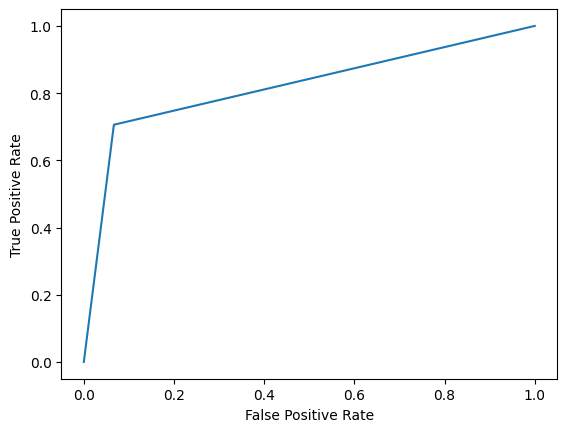

ROC AUC: 0.8196
Accuracy: 0.8125
F1 Score: 0.8000


In [671]:
# roc auc curve and accuracy % and f1 score
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

with torch.no_grad():
    y_true = []
    y_pred = []
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = torch.round(torch.sigmoid(outputs))
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        
roc_auc = roc_auc_score(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# plot roc auc curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print(f'ROC AUC: {roc_auc:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')

        

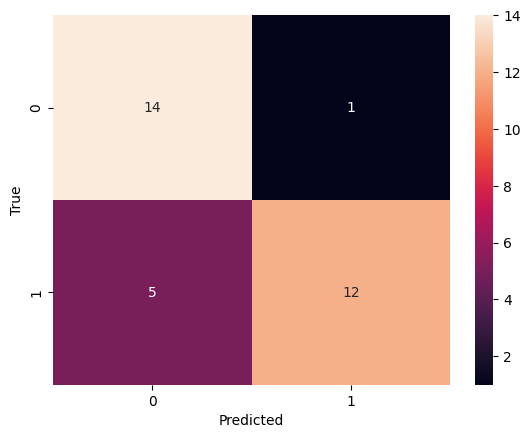

In [672]:
# confusion matrix seaborn
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = torch.round(torch.sigmoid(outputs))
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())
        
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

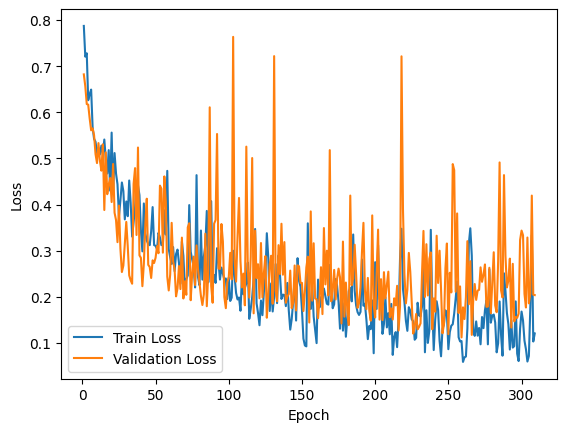

In [673]:
import matplotlib.pyplot as plt

plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [674]:
# Save the model
torch.save(model.state_dict(), '/Users/defeee/Documents/GitHub/FormAI-ML/Models/Core/Squat/squat_nn.pth')